# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

%matplotlib notebook
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | head -n 5

{"movieId": 2, "userId": 1, "timestamp": 1112486027, "rating": 3.5}
{"movieId": 29, "userId": 1, "timestamp": 1112484676, "rating": 3.5}
{"movieId": 32, "userId": 1, "timestamp": 1112484819, "rating": 3.5}
{"movieId": 47, "userId": 1, "timestamp": 1112484727, "rating": 3.5}
{"movieId": 50, "userId": 1, "timestamp": 1112484580, "rating": 3.5}
cat: Unable to write to output stream.


In [128]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

## Exercise 3.4 Basic statistics
First, we will look at basic statistics on this dataset.
* Plot the number of ratings for each user.
* Plot the number of ratings for each item.

Is the number of ratings balanced uniformly across users and movies?

In [4]:
UID = data.map(lambda x: (x["userId"], 1))
UID_count = UID.reduceByKey(lambda a, b: a + b)
user_ratings = np.array(UID_count.collect())

In [5]:
user_ratings

array([[ 99756,     25],
       [ 99768,    182],
       [ 99780,    145],
       ...,
       [138467,    298],
       [138479,     35],
       [138491,     22]])

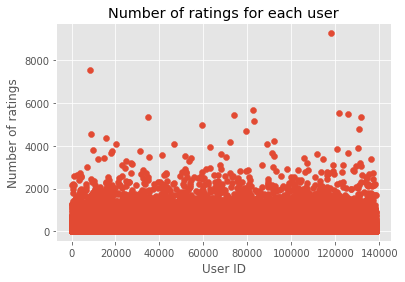

In [6]:
userID = user_ratings[:,0]
Number_ratings = user_ratings[:,1]
plt.scatter(userID,Number_ratings)
plt.title('Number of ratings for each user')
plt.xlabel('User ID')
plt.ylabel('Number of ratings')
plt.show()

In [7]:
UID = data.map(lambda x: (x["movieId"], 1)) # Maybe change the name of this varible
UID_count = UID.reduceByKey(lambda a, b: a + b)
item_ratings = np.array(UID_count.collect())

Text(0, 0.5, 'Number of ratings')

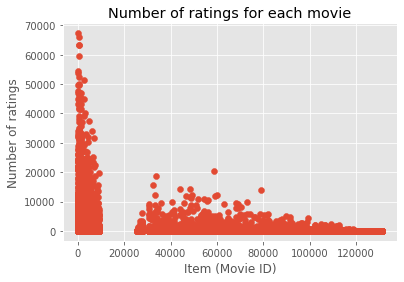

In [8]:
Item = item_ratings[:,0]
Number_ratings = item_ratings[:,1]
plt.scatter(Item,Number_ratings)
plt.title('Number of ratings for each movie') #Edit made
plt.xlabel('Item (Movie ID)')
plt.ylabel('Number of ratings')

With the two previous graphs, we observe that about all users gave rates but not all the items are rated (And the rating of the items is heavily skewed to the right). Thus the number of ratings is not balanced uniformly across users and movies.

## Exercise 3.5 Partitioning the dataset
In order to tune hyperparameters and evaluate the recommender system’s performance, we
will split the data into a training and a validation set.
* Append your personal ratings to the MovieLens dataset RDD.
* Partition the data into two sets: ≈ 80% for training, and ≈ 20% for validation.

**Hint**: A convenient way to split the data is to filter on the last digit of the rating’s timestamp

float

### Adding my personal ratings

In [129]:
lines = [{"movieId": 2, "userId": 138494, "timestamp": 1588151190, "rating": 2.0},
         {"movieId": 47, "userId": 138494, "timestamp": 1588151191, "rating": 4.0},
         {"movieId": 70, "userId": 138494, "timestamp": 1588151209, "rating": 3.0},
         {"movieId": 260, "userId": 138494, "timestamp": 1588151210, "rating": 5.0},
         {"movieId": 357, "userId": 138494, "timestamp": 1588151211, "rating": 3.1},         
         {"movieId": 541, "userId": 138494, "timestamp": 1588151213, "rating": 5.0},         
         {"movieId": 587, "userId": 138494, "timestamp": 1588151215, "rating": 2.3},
         {"movieId": 593, "userId": 138494, "timestamp": 1588151217, "rating": 5.0},
         {"movieId": 673, "userId": 138494, "timestamp": 1588151218, "rating": 3.3},
         {"movieId": 613, "userId": 138494, "timestamp": 1588151220, "rating": 3.1},
         {"movieId": 780, "userId": 138494, "timestamp": 1588151226, "rating": 3.0},
         {"movieId": 784, "userId": 138494, "timestamp": 1588151254, "rating": 2.0},
         {"movieId": 924, "userId": 138494, "timestamp": 1588151290, "rating": 4.8}]

# Append to the Hdfs ratings.txt file
my_rates = sc.parallelize(lines)
print(my_rates.take(10))
data = data.union(my_rates)

[{'movieId': 2, 'userId': 138494, 'timestamp': 1588151190, 'rating': 2.0}, {'movieId': 47, 'userId': 138494, 'timestamp': 1588151191, 'rating': 4.0}, {'movieId': 70, 'userId': 138494, 'timestamp': 1588151209, 'rating': 3.0}, {'movieId': 260, 'userId': 138494, 'timestamp': 1588151210, 'rating': 5.0}, {'movieId': 357, 'userId': 138494, 'timestamp': 1588151211, 'rating': 3.1}, {'movieId': 541, 'userId': 138494, 'timestamp': 1588151213, 'rating': 5.0}, {'movieId': 587, 'userId': 138494, 'timestamp': 1588151215, 'rating': 2.3}, {'movieId': 593, 'userId': 138494, 'timestamp': 1588151217, 'rating': 5.0}, {'movieId': 673, 'userId': 138494, 'timestamp': 1588151218, 'rating': 3.3}, {'movieId': 613, 'userId': 138494, 'timestamp': 1588151220, 'rating': 3.1}]


Now our rates are appended to the whole dataset

### Partitioning the dataset

In [7]:
def RDDfilter80(line):
    """Filters the RDD in order to keep ~80% of the Data for training"""
    keep = True
    if line['timestamp']%10 in [0,1]:
        keep = False
    return(keep)

def RDDfilter20(line):
    """Filters the RDD in order to keep ~20% of the Data for training"""
    keep = False
    if line['timestamp']%10 in [0,1]:
        keep = True
    return(keep)

# Filters the dataset to split it into 2 datasets
# it uses the last digit of the timestamp to do it 
# if the digit is in [0,1] it will be taken for the test dataset and
# if the digit is in [2,3,4,5,6,7,8,9] it will be put in the training dataset
train = data.filter(RDDfilter80)
test = data.filter(RDDfilter20)

In [5]:
ratio_train = train.count()/data.count()
ratio_test = test.count()/data.count()
print('The training partition represents '+str(round(ratio_train*100,2)) +'% of the data')
print('The test partition represents '+str(round(ratio_test*100,2)) +'% of the data')

The training partition represents 80.0% of the data
The test partition represents 20.0% of the data


## Exercise 3.6 Baseline model

You will first implement a recommender system based on model (3.1).
* Compute the global mean µ , the user biases {α u } and the item biases {β m } using a
sequence of RDD transformations on the training set.
* How many parameters does this model have?
* Predict the rating of every user / movie pair in the validation set.

**Note**: some users / movies do not have any ratings. Use sensible default values for α u and β m 

We used the following formulas :
$$\mu = \frac{1}{N}\sum_{u,m}^{} r_{um}$$
    $$\alpha_{u} = \frac{1}{N_{u}}\sum_{m}^{} (r_{um}-\mu)$$
$$\beta_{m} = \frac{1}{N_{m}}\sum_{u}^{} (r_{um}-\alpha_{u}-\mu)$$

In [12]:
# Definition of some parameters
N = train.count() 

In [13]:
# Get the Nm for each movie
data_mov = train.map(lambda x: (x['movieId'],1))
count_movie = data_mov.reduceByKey(lambda a,b:a+b)
Nm = dict(count_movie.collect())

In [14]:
# Get the Nu for each u
data_user = train.map(lambda x: (x['userId'],1))
count_user = data_user.reduceByKey(lambda a,b:a+b)
Nu = dict(count_user.collect())

In [15]:
# Computes the global average
rum = train.map(lambda x: x["rating"])
mu = rum.sum()/N
print("µ = "+str(mu))

µ = 3.5255072209782274


The following snippet of code computes the $\alpha_{u}$ for each user

In [16]:
def reducer(r1,r2):
    return(r1+r2)

rum = train.map(lambda x:(x["userId"], x["rating"]))
rum_uid = rum.reduceByKey(reducer)
alpha_uid = rum_uid.collect()

def calc_alpha(x):
    uid, sum_rum = x
    s = sum_rum/Nu[int(uid)] - mu
    return s

# Terminate calculations
tab = np.array(alpha_uid)
alpha_user = pd.DataFrame(tab) 
alpha_user['alpha_u'] = alpha_user.apply(calc_alpha, axis=1)
alpha_user.columns = ["uId", "rum_sum", "alpha_u"]
alpha_user

,uId,rum_sum,alpha_u
0,40.0,200.0,-0.135677
1,80.0,83.0,0.083188
2,120.0,136.0,-0.038328
3,160.0,420.0,-0.165507
4,200.0,217.0,0.152459
...,...,...,...
138453,138319.0,82.0,0.039710
138454,138359.0,53.0,-0.581063
138455,138399.0,330.0,0.182358
138456,138439.0,255.0,-0.079561


We finally get, a dataframe with the user ID and the corresponding $\alpha_{u}$

The following snippet of code computes the $\beta_{u}$ for each item
$$\beta_{m} = \frac{1}{N_{m}}(\sum_{u}^{} r_{um} -\sum_{u}^{} \alpha_{u})-\mu$$

In [17]:
def reducer(r1,r2):
    return(r1+r2)

# GROUPBY Movie ID and sum the ratings
rum = train.map(lambda x:(x["movieId"], x["rating"]))
rum_mId = rum.reduceByKey(reducer)
rum_mId = rum_mId.collect()

# Store it in a dataframe
tab = np.array(rum_mId)
beta_mId = pd.DataFrame(tab) 
beta_mId.columns = ["movieId", "rum_sum"]
beta_mId.head()

,movieId,rum_sum
0,1080.0,65393.0
1,1920.0,8428.5
2,3000.0,31576.5
3,4720.0,29578.5
4,5040.0,4003.5


In [18]:
# Run it to regenerate Beta otherwise they are stored in a file.
def reducer(r1,r2):
    return(r1+r2)
def get_alpha_u(u):
    return(alpha_user[alpha_user['uId']==int(u)]['alpha_u'].values[0])

# Create couples (Movie ID, alpha_u)
rum = train.map(lambda x:(x["movieId"],get_alpha_u(x["userId"])))
rum_mId = rum.reduceByKey(reducer)
res = rum_mId.collect()
# np.save("resultat_sum_alpha_u_movie_m", res)

In [19]:
if not("res" in locals()):
    # Load data if already computed
    res = np.load("resultat_sum_alpha_u_movie_m.npy")
    
alpha_um = dict(res)

def calc_beta(x):
    movieId, sum_rum = x
    s = (sum_rum-alpha_um[int(movieId)])/Nm[int(movieId)] - mu
    return s

# Perform the computations to get beta and store it in the dataframe
beta_mId['beta_m'] = beta_mId.apply(calc_beta, axis=1)
beta_mId.head()

,movieId,rum_sum,beta_m
0,1080.0,65393.0,0.401877
1,1920.0,8428.5,-0.607751
2,3000.0,31576.5,0.500964
3,4720.0,29578.5,0.194374
4,5040.0,4003.5,-0.541324


In [20]:
#Bakup from the data in order to load them without recomputing them
np.save('N', N)
np.save('Nu', Nu)
np.save('Nm', Nm)
np.save('mu', mu)
np.save('alpha_user', alpha_user)
np.save('beta_mId', beta_mId)

Now we have computed all what we needed to compute the predicted rate.

This model has only **two** parameters which are $u,m$

Now to perform the prediction we used the folowing formula :

$$\hat r_{um} = \mu + \alpha_{u} + \beta_{m}$$

In [24]:
# Load the data from the bakup, if computation has already be done
N = np.load('N.npy')
Nu = np.load('Nu.npy')
Nm = np.load('Nm.npy')
mu = np.load('mu.npy')
alpha_user = np.load('alpha_user.npy')
beta_mId = np.load('beta_mId.npy')

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [25]:
# Functions to attributes the alpha_u and beta_m
# If nothing is rated it attributes the mean of the corresponding ratings
alpha_default = alpha_user["alpha_u"].mean()
beta_default = beta_mId["beta_m"].mean()

def get_alpha(u):
    """Returns the corresponding alpha for the user u
    If the data is missing, the average of the alpha is returned"""
    #   Check Alpha
    search_alpha = alpha_user[alpha_user["uId"]==u]["alpha_u"].values
    if len(search_alpha)==0:
        alpha = alpha_default
    else:
        alpha = search_alpha[0]
    return (alpha)

def get_beta(m):
    """Returns the corresponding beta for the movie m
    If the data is missing, the average of the beta is returned"""
    #   Check Beta
    search_beta = beta_mId[beta_mId['movieId']==m]["beta_m"].values
    if len(search_beta)==0:
        beta = beta_default
    else:
        beta = search_beta[0]
    return(beta)

def predict(u,m):
    """return the prediction of the rate for user u and movie m"""
#   Get Alpha
    search_alpha = alpha_user[alpha_user["uId"]==u]["alpha_u"].values
    if len(search_alpha)==0:
        alpha = alpha_default
    else:
        alpha = search_alpha[0]
#   Get Beta
    search_beta = beta_mId[beta_mId['movieId']==m]["beta_m"].values
    if len(search_beta)==0:
        beta = beta_default
    else:
        beta = search_beta[0]
#     Finally perform the sum
    val=mu+alpha+beta
    return val

In [26]:
# To fetch the data from the test or validation dataset 
test_np = test.collect()
df = pd.DataFrame(test_np)
df.head()

,movieId,userId,timestamp,rating
0,50,1,1112484580,3.5
1,112,1,1094785740,3.5
2,253,1,1112484940,4.0
3,367,1,1112485980,3.5
4,593,1,1112484661,3.5


In [27]:
# Attributes the alpha_u and beta_m to each (u, m) couples
df["alpha_u"] = df[["userId"]].apply(lambda x : get_alpha(x["userId"]), axis=1)
df["beta_m"] = df[["movieId"]].apply(lambda x : get_beta(x["movieId"]), axis=1)

KeyboardInterrupt: 

In [ ]:
df.head(5)

In [ ]:
# Perform the addition of the columns containing alpha_u and beta_m and add the mean to them
tab = df.to_numpy()
rum_pred = tab[:,4]+tab[:,5]+mu 
df["rum_pred"] = rum_pred
# Save the dataset after all the computations are done
np.save("df",df.values)

In [23]:
df.head()

NameError: name 'df' is not defined

Now our predictions are done, thus we can compare them with the real data.

## Exercise 3.7 Evaluation
Implement a function error() that takes an RDD containing (userId, movieId, rating)
triplets and computes the error (3.2) with respect to the validation set.
• Use this function to evaluate the baseline predictions that you computed previously.
You should obtain an error of approximately 0.867. 

In [22]:
# Load the Dataset containing the preceding data
df = np.load("df.npy")
df = pd.DataFrame(df)
df.columns = ["movieId", "userId","timestamp", "rating", "alpha_u", "beta_m", "rum_pred"]
df = df.astype({'movieId': 'int32', 'userId': 'int32'})
df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'df.npy'

In [131]:
def error():
    # Get the Nu for each u
    data_user = test.map(lambda x: (x['userId'],1))
    count_user = data_user.reduceByKey(lambda a,b:a+b)
    Nu = dict(count_user.collect())
    
    users = df["userId"].unique()
    U = len(users)
    s = 0
    # Compute the error formula     
    df['delta^2'] = (df["rum_pred"]-df["rating"])**2
    delta_by_user = df.groupby("userId").sum()

    for u in users:
        s += np.sqrt((1/Nu[u])*delta_by_user[delta_by_user.index.astype(int)==u]['delta^2'].values[0])
    err = (1/U)* s
    return err
    
err = error()
print("We get an error of "+str(round(err,4)))

We get an error of 0.8684


Hence we can say that our recommender system is about **0.8684** from the perfect recommandations. It can be 0.8684 above or below the real value.

## 3.8

We now consider a more powerful class of models based on factorizing the rating matrix.
Spark provides the function pyspark.mllib.recommendation.ALS() to learn such models.
A typical loop will consist of:

1. learning a model with ALS()
2. predicting ratings on the validation set using model.predictAll()
3. evaluating the predictions using error()

Decide on a rank for your model, e.g., between 5 and 25. What is the trade-off between
choosing a lower and a higher rank?
* Set the regularization parameter lambda_ to 10−4
* How accurate are the predicted
ratings? Can you explain the phenomenon?
* Now set lambda_ to 10.0. What happens to the predicted ratings, and why?
* Find the value of lambda_ that minimizes the validation error.

What improvement do you get over the error of the baseline recommender system? 


In [196]:
# They suggest pyspark.mllib instead I saw in the end, it might make some difference. 
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from operator import itemgetter

In [195]:
from pyspark.mllib.recommendation import MatrixFactorizationModel

In [8]:
def als_model(rank=5,learning_rate = 10e-4, df=train):
    als = ALS(rank = rank, maxIter=5, regParam=learning_rate, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative=True)
    model = als.fit(spark.createDataFrame(df).dropna())
    predictions = model.transform(spark.createDataFrame(test).dropna())
    error = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = error.evaluate(predictions)
    return model, rmse

In [9]:
# Calculating the rmse with constant learning rate and different rank. This to see how the rank impacts the error
#learning_rate = 10e-4
#(model_r5, rmse5) = als_model(rank=5,learning_rate = learning_rate)
#(model_r10, rmse10) = als_model(rank=10,learning_rate = learning_rate)
#(model_r15, rmse15) = als_model(rank=15,learning_rate = learning_rate)
#(model_r20, rmse20) = als_model(rank=20,learning_rate = learning_rate)
#(model_r25, rmse25) = als_model(rank=25,learning_rate = learning_rate)

#rmse = {'rmse5' : rmse5, 'rmse10': rmse10, 'rmse15': rmse15, 'rmse20': rmse20, 'rmse25': rmse25}

In [52]:
rmse = {'rmse5' : rmse5, 'rmse10': rmse10, 'rmse15': rmse15, 'rmse20': rmse20, 'rmse25': rmse25}
dict((k, np.round(v,4)) for k,v in rmse.items())

{'rmse5': 1.0742,
 'rmse10': 0.8388,
 'rmse15': 0.848,
 'rmse20': 0.8703,
 'rmse25': 0.8941}

We see that after rank = 10 our rmse does actually not improve and instead is worse. We thus choose our rank to be 10. Rank in the case of ALS is the number of latent factors we use in our model. The more latent factors, which means the thigher the rank, the more computationally demanding the code becomes. 

In [53]:
(model_l10, rmse_l10) = als_model(rank=10,learning_rate = 10)

In [55]:
rmse_l10

3.679390579552639

In [36]:
def find_optimal_als(ranks, learning_rates):
    best_model = None
    best_rank = None
    best_learning_rate = None
    min_rmse = 10000 # Just an arbitrary big number
    for rank in ranks:
        for learning_rate in learning_rates:
            (temp_model, temp_rmse) = als_model(rank=5,learning_rate = learning_rate)
            if temp_rmse < min_rmse:
                min_rmse = temp_rmse
                best_model = temp_model
                best_rank = rank
                best_learning_rate = learning_rate
    return best_model, best_rank, best_learning_rate, min_rmse


In [67]:
# Check for a few different ranks and learning rates the model that reduces rmse. 
ranks = [8, 9, 10, 11, 12]
learning_rates = [10e-4, 0.01, 0.1, 1, 2.5, 5, 10]
(best_model, best_rank, best_learning_rate, min_rmse) = find_optimal_als(ranks, learning_rates)

In [70]:
print(best_rank)
print(best_learning_rate)

9
0.1


In [9]:
(best_model, rmse_l10) = als_model(rank=9,learning_rate = 0.1)

/usr/hdp/current/spark2-client/python/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [14]:
best_model = model_l10

In [10]:
rmse_l10

0.8272731588376437

## 3.9

Create a Python dict that maps from movie IDs to movie titles based on the file movies.txt.
* Recommend 10 movies for user 123 using model.recommendProducts(). What kind
of movies does the model think the user will like?
* Recommend 10 movies to yourself (user ID: 138494).

What do you think of your recommendations? :-) 

In [19]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movie_id_to_title = dict(movies.map(itemgetter("movieId", "title")).collect())

In [10]:
(complete_model, rmse_c) = als_model(rank=9,learning_rate = 0.1, df=data)

/usr/hdp/current/spark2-client/python/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [21]:
def recommend_for_users(users, n):
    all_recommendations = complete_model.recommendForAllUsers(10)
    recommendations = {}
    for u in users:
        temp_recs = all_recommendations.filter(all_recommendations['userId'] == u)
        temp_recs = list(temp_recs.toPandas()['recommendations'])[0]
        d = {}
        for i in temp_recs:
            d[movie_id_to_title[i[0]]] = np.round(i[1],2)
        recommendations[u] = d
    return recommendations

In [22]:
users = [123, 138494]
recommend_for_users(users, 10)

{123: {'Marihuana (1936)': 6.91,
  'No Distance Left to Run (2010)': 5.01,
  'My Brother Tom (2001)': 4.76,
  'Island at War (2004)': 4.71,
  'Diplomatic Immunity (2009– )': 4.71,
  'Code Name Coq Rouge (1989)': 4.69,
  'Moth, The (Cma) (1980)': 4.57,
  'Bill Hicks: Sane Man (1989)': 4.56,
  'Yesterday Was a Lie (2008)': 4.46,
  "It's Love I'm After (1937)": 4.43},
 138494: {'Marihuana (1936)': 7.68,
  'No Distance Left to Run (2010)': 5.77,
  'Moth, The (Cma) (1980)': 5.52,
  'Hellhounds on My Trail (1999)': 5.44,
  'Code Name Coq Rouge (1989)': 5.38,
  'My Brother Tom (2001)': 5.26,
  'Crooks in Clover (a.k.a. Monsieur Gangster) (Les tontons flingueurs) (1963)': 5.21,
  'I Belong (Som du ser meg) (2012)': 5.19,
  'Otakus in Love (2004)': 5.16,
  "It's Love I'm After (1937)": 5.15}}

## Exercise 3.10 Visualisation
Learn a rank-2 matrix-factorization model using ALS().
* Extract the features for all the movies in selected-movies.pickle.
* Create an interactive plot that embeds the movies along the 2 directions defined by the
factorization.
* Describe what you observe. Can you give a name to the dimensions? Do you recognize
cluster of movies that are alike?
Note: you can reuse some of the code that you wrote for Exercise 3.3.

In [37]:
ranks = [2]
learning_rates = [10e-4, 0.005, 0.01, 0.05,0.1]
(best_model, best_rank, best_learning_rate, min_rmse) = find_optimal_als(ranks, learning_rates)

/usr/hdp/current/spark2-client/python/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [138]:
best_rank, best_learning_rate

(2, 0.1)

In [23]:
features = sc.textFile("/ix/ml-20m/selected-movies.pickle").map(json.loads)

In [ ]:
movie_id_to_title = dict(movies.map(itemgetter("movieId", "title")).collect())

In [45]:
import pickle
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")

In [58]:
list(movies)

[(780, 'Independence Day (a.k.a. ID4) (1996)', 0.6),
 (5349, 'Spider-Man (2002)', 0.89),
 (2571, 'Matrix, The (1999)', 0.87),
 (318, 'Shawshank Redemption, The (1994)', 0.91),
 (2329, 'American History X (1998)', 0.83),
 (5147, 'Wild Strawberries (Smultronstället) (1957)', 0.95),
 (55444, 'Control (2007)', 0.87),
 (32296, 'Miss Congeniality 2: Armed and Fabulous (2005)', 0.15),
 (43930, 'Just My Luck (2006)', 0.13),
 (4658, 'Santa Sangre (1989)', 0.85),
 (6774, 'Videodrome (1983)', 0.78),
 (3967, 'Billy Elliot (2000)', 0.85),
 (114028, 'Pride (2014)', 0.92),
 (480, 'Jurassic Park (1993)', 0.93),
 (260, 'Star Wars: Episode IV - A New Hope (1977)', 0.93),
 (4700, 'Princess Diaries, The (2001)', 0.47),
 (527, "Schindler's List (1993)", 0.96),
 (2959, 'Fight Club (1999)', 0.79),
 (6132, 'New York Ripper, The (Squartatore di New York, Lo) (1982)', 0.17),
 (2858, 'American Beauty (1999)', 0.88),
 (6016, 'City of God (Cidade de Deus) (2002)', 0.9),
 (94018, 'Battleship (2012)', 0.34),
 (5687,

In [159]:
import random as rand
lines2 = list({'movieId': k, 'userId': 138495, 'timestamp': 1588151291 + int(rand.random()*(v+1)*1000), 'rating': np.round(v*5,1).item()} for (k, a, v) in list(movies))
lines2 = sorted(lines2, key = lambda i: i['movieId'])
my_rates2 = sc.parallelize(lines2)
#data = data.union(my_rates2)